In [1]:
# Import other useful Python packages
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import spikesorting_fullpursuit as fbp

IMPORT MATPLOT LIB 474


In [3]:
from spikesorting_fullpursuit.test import gen_dataset 

In [4]:
# Start by setting up a gen_dataset object to make and sort synthetic data
n_chans = 4 # Number of channels to make in test dataset
v_duration = 60 # Test dataset duration in seconds
random_seed = None # Set seed of numpy random number generator for spike times
neuron_templates = None # Just use default pre-loaded template waveforms to generate spike voltage traces
frequency_range = (300, 6000) # Frequencies of dataset in Hz
samples_per_second = 40000 # Sampling rate of 40kHz
amplitude = 1 # Amplitude of 3 standard deviations of noise
percent_shared_noise = .3 # Create share d noise across channels
correlate1_2 = (.10, 10) # Set 15% of neuron 2 spikes to occur within 10 samples of a neuron 1 spike
electrode_type = 'tetrode' # Choose pre-loaded electrode type of tetrode and all channels in neighborhood
voltage_dtype = np.float32 # Create voltage array as float 32

# Create the test dataset object
test_data = gen_dataset.TestDataset(n_chans, v_duration, random_seed, neuron_templates, frequency_range, 
                                    samples_per_second, amplitude, percent_shared_noise,
                                    correlate1_2, electrode_type, voltage_dtype)

In [5]:
# Generate the noise voltage array, without spikes, assigned to test_date.voltage_array
test_data.gen_noise_voltage_array()

In [6]:
# Specify the neurons' properties in the dataset
firing_rates = np.array([90, 100]) # Firing rates
template_inds = np.array([1, 0]) # Templates used for waveforms
chan_scaling_factors = np.array([[1.85, 2.25, 1.65, .5], [3.85, 3.95, 1.95, 3.7]]) # Amplitude of neurons on each of the 4 channels
refractory_win = 1.5e-3 # Set refractory period at 1.5 ms

In [7]:
# Generate the test dataset by choosing spike times and adding them according to the specified properties
test_data.gen_test_dataset(firing_rates, template_inds, chan_scaling_factors, refractory_win)

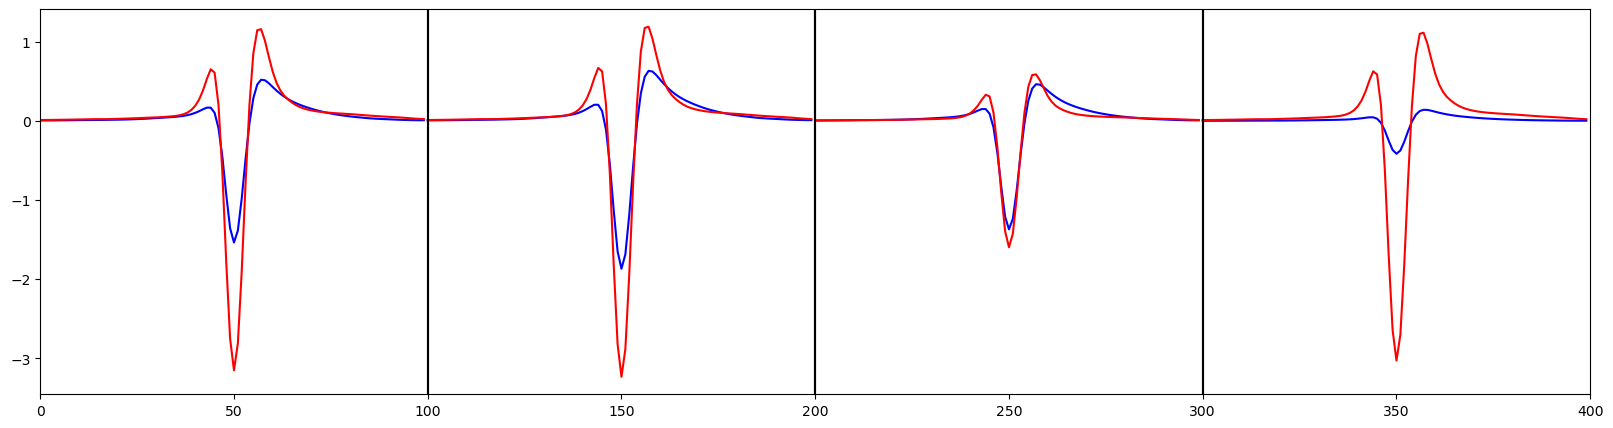

In [8]:
# Plot the two templates used to generate spikes. Templates are concatenated horizontally across channels for plotting.
w_color = ['b', 'r']

# Plot each neuron template
n_neurons = len(test_data.actual_templates)
for n in range(0, n_neurons): 
    use_color = w_color.pop(0)
    
    # Plot template for each channel
    n_template_channels = test_data.actual_templates[n].shape[0]
    n_template_samples = test_data.actual_templates[n].shape[1]
    for chan in range(0, n_template_channels): 
        chan_x_inds = np.arange(n_template_samples*chan, n_template_samples*(chan+1))
        _ = plt.plot(chan_x_inds, test_data.actual_templates[n][chan, :], color=use_color)
        
        # Add vertical lines to delineate channel boundaries for templates
        if chan > 0:
            plt.axvline(n_template_samples*chan, color='k')
ag = plt.gcf()
ag.set_size_inches(20, 5)
_ = plt.xlim([0, n_template_channels*n_template_samples])

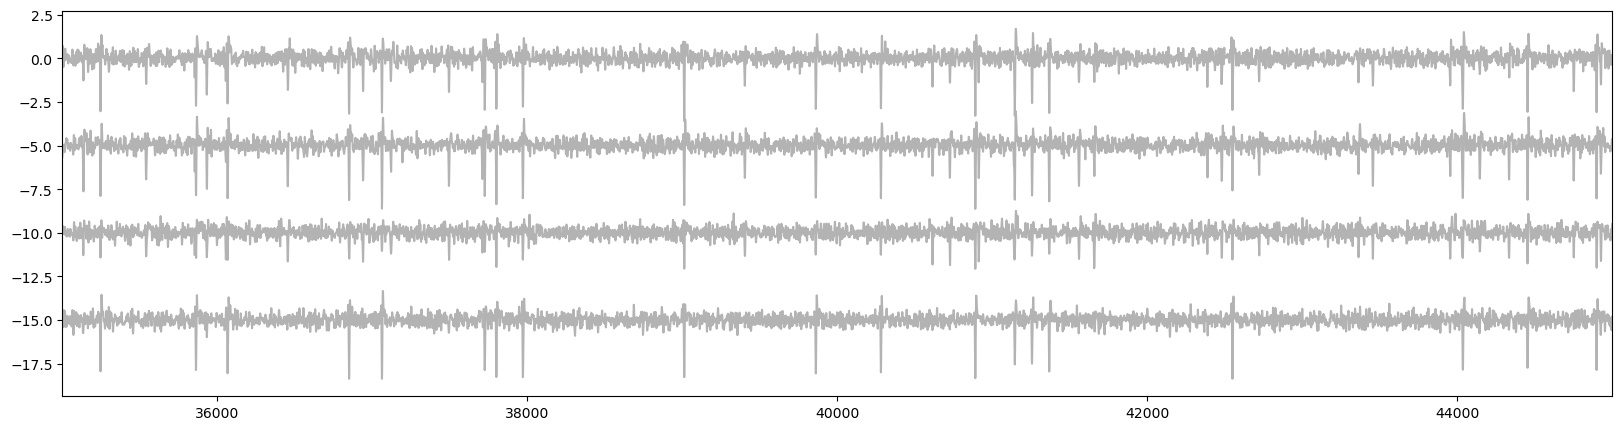

In [9]:
# Plot the synthetic voltage for each channel within the window "v_boundaries" to see that we have successfully added spikes
v_boundaries = [40000 - 5000, 40000 + 5000]
for chan in range(0, test_data.num_channels):
    plt.plot(np.arange(v_boundaries[0], v_boundaries[1]), 
             test_data.Probe.voltage[chan, v_boundaries[0]:v_boundaries[1]] - chan*5, color=[.7, .7, .7])
ag = plt.gcf()
ag.set_size_inches(20, 5)
_ = plt.xlim(v_boundaries)

In [10]:
# Run the sorting algorithm on the synthetically generated dataset.

# Some of the possible input variables extracted to play with
sigma = 4.0 # Sigma for detecting events/spike clips
clip_width = [-10e-4, 10e-4] # Spike clip width used for finding templates (in ms)
check_components = 20 # Number of PCs to check when searching for best PCs to use
max_components = 5 # Maximum number of PCs to use for clustering
p_value_cut_thresh = .01 # P-value used to determine whether to split clusters in iso-cut algorithm
sigma_bp_noise = 2.326 # Threshold for adding spikes in binary pursuit relative to expected noise variance
log_dir = None # You can optionally enter a directory string where more detailed text about the sorting progress and errors will be printed.

# Resets random seed to the one last used so that results are repeatable
np.random.set_state(test_data.random_state)

# Enter the remaining variables for clarity. Run sorter and get outputs.
sort_data, work_items, sort_info = test_data.sort_test_dataset_parallel({'p_value_cut_thresh': p_value_cut_thresh, 'sigma': sigma,
                                       'clip_width': clip_width, 'check_components': check_components, 
                                       'max_components': max_components, 'verbose': True, 'do_ZCA_transform': True,
                                       'min_firing_rate': 0.1, 'add_peak_valley': False,
                                       'do_branch_PCA': True, 'max_gpu_memory': .1 * (1024 * 1024 * 1024),
                                       'use_rand_init': True, 'segment_duration': 30, 'segment_overlap': 15, 
                                       'test_flag': False, 'log_dir': log_dir, 'do_branch_PCA_by_chan': True, 'sort_peak_clips_only': True,
                                        'get_adjusted_clips': False,
                                        'n_cov_samples': 20000,
                                        'sigma_bp_noise': sigma_bp_noise, 'sigma_bp_CI': 12.0, 
                                        'max_binary_pursuit_clip_width_factor': 1.,
                                        'do_overlap_recheck': True})

Input segment duration was rounded from 30 up to 30.0 seconds to make segments equal length.
Using  3 segments per channel for sorting.
Doing parallel ZCA transform and thresholding for 3 segments
No log dir specified. Won't be able to see output from processes
Start clustering for Wiener filter templates.
Starting sorting pool
Starting item 1/12 on CPUs [0] for channel 1 segment 2
Identifying threshold crossings
Using minimum cluster size of 3
Starting item 2/12 on CPUs [1] for channel 1 segment 3
Identifying threshold crossings
Using minimum cluster size of 3
Starting item 3/12 on CPUs [2] for channel 1 segment 1
After keep max on main removed 1904 clips
Start initial clustering and merge
Identifying threshold crossings
Using minimum cluster size of 3
Starting item 4/12 on CPUs [3] for channel 0 segment 2
After keep max on main removed 1949 clips
Start initial clustering and merge
Identifying threshold crossings
Using minimum cluster size of 3
Starting item 5/12 on CPUs [4] for chann

In [11]:
# First step in automated post-processing
# Set a few variables that can allow easy detection of units that are poor
absolute_refractory_period = 10e-4 # Refractory period (in ms) will be used to determine potential violations in sorting accuracy
# Max allowable ratio between refractory period violations and maximal bin of ACG. Units that violate will be deleted. Setting to 1. allows all units
max_mua_ratio = 1. 
min_snr = 0 # Minimal SNR a unit must have to be included in post-processing
min_overlapping_spikes = .75 # Percentage of spikes required with nearly identical spike times in adjacent segments for them to combine in stitching

# Create the work_summary postprocessing object
work_summary = fbp.postprocessing.WorkItemSummary(sort_data, work_items, sort_info, 
                                           absolute_refractory_period=absolute_refractory_period, max_mua_ratio=max_mua_ratio,
                                           min_snr=min_snr, min_overlapping_spikes=min_overlapping_spikes, 
                                           verbose=False)

Least MUA removed was inf on channel None segment None
Maximum SNR removed was -inf on channel None segment None


In [12]:
# No segments in the example (segment_duration > duration of synthetic data) but done as example
work_summary.stitch_segments()

Start stitching channel 0
Start stitching channel 1
Start stitching channel 2
Start stitching channel 3


In [13]:
# Summarize the sorted output data into dictionaries by time segment. 
work_summary.summarize_neurons_by_seg()

In [14]:
# Finally summarize neurons across channels (combining and removing duplicate neurons across space) to get a list of sorted "neurons"
neurons = work_summary.summarize_neurons_across_channels(overlap_ratio_threshold=np.inf,
                                                         min_segs_per_unit=1,
                                                         remove_clips=False)

Redundant neurons already removed at threshold >= inf Further attempts will have no effect.
Skipping remove_redundant_neurons_by_seg.


In [15]:
# Print out some basic information about our sorted units like number of spikes, firing rate, SNR, proportion MUA ISI violations
fmtL = "Unit: {:.0f} on chans {}; n spikes = {:.0f}; FR = {:.0f}; Dur = {:.0f}; SNR = {:.2f}; MUA = {:.2f}; TolInds = {:.0f}"
for ind, n in enumerate(neurons):
    print_vals = [ind, n['channel'], n['spike_indices'].size, n['firing_rate'], n['duration_s'], n['snr']['average'], n['fraction_mua'], n['duplicate_tol_inds']]
    print(fmtL.format(*print_vals))

Unit: 0 on chans [1]; n spikes = 5901; FR = 98; Dur = 60; SNR = 5.44; MUA = 0.00; TolInds = 8
Unit: 1 on chans [1]; n spikes = 5334; FR = 89; Dur = 60; SNR = 3.27; MUA = 0.01; TolInds = 9
Unit: 2 on chans [2]; n spikes = 405; FR = 14; Dur = 30; SNR = 3.05; MUA = 0.00; TolInds = 10


In [16]:
# Match the ground truth units to the sorted neurons with the most true positives
test_match_to_neurons = {}
for test_num in range(0, len(test_data.actual_IDs)):
    max_true_positives = -np.inf
    for unit_num in range(0, len(neurons)):
        overlapping_spike_bool = fbp.analyze_spike_timing.find_overlapping_spike_bool(test_data.actual_IDs[test_num], 
                                                                                      neurons[unit_num]['spike_indices'], overlap_tol=10)
        true_positives = np.count_nonzero(overlapping_spike_bool)
        if true_positives > max_true_positives:
            max_true_positives = true_positives
            test_match_to_neurons[test_num] = unit_num

for test_num in range(0, len(test_data.actual_IDs)):
    print("Matched actual unit", test_num, "to sorted neuron", test_match_to_neurons[test_num])

Matched actual unit 0 to sorted neuron 1
Matched actual unit 1 to sorted neuron 0


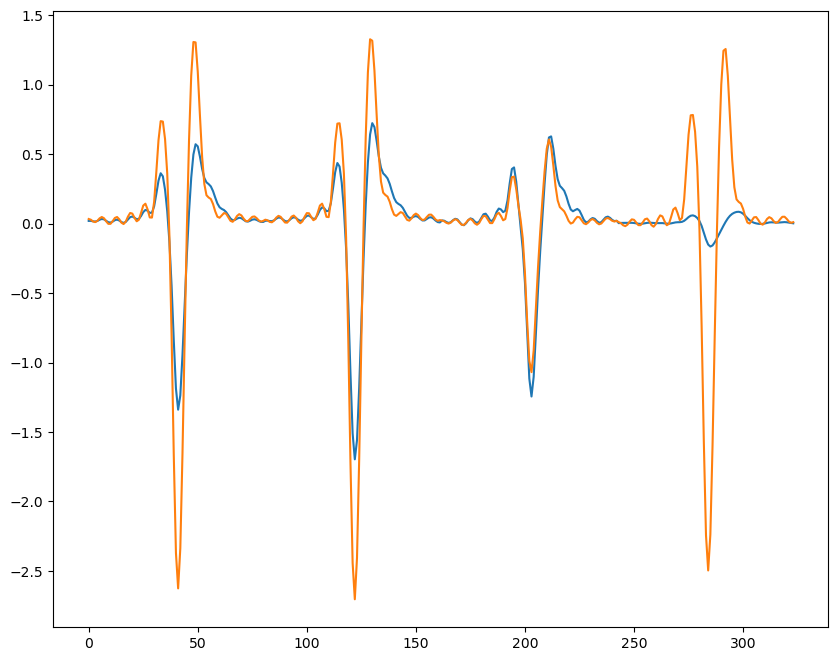

In [17]:
# Plot the templates of the sorted neurons
for n in test_match_to_neurons:
    n_num = test_match_to_neurons[n]
    for chan in neurons[n_num]['channel']:
        plt.plot(neurons[n_num]['template'][chan][0:])
ag = plt.gcf()
ag.set_size_inches(10, 8)

In [18]:
# Print true positive and false discoveries for best matching to ground truth neuron 1
ground_truth_unit = 0
tol_inds = 10 # Match within a tolerance of 10 time samples
overlapping_spike_bool = fbp.analyze_spike_timing.find_overlapping_spike_bool(test_data.actual_IDs[ground_truth_unit], neurons[test_match_to_neurons[ground_truth_unit]]['spike_indices'], overlap_tol=tol_inds)
true_positives = np.count_nonzero(overlapping_spike_bool)

print("False discoveries are", 100 * (neurons[test_match_to_neurons[ground_truth_unit]]['spike_indices'].size - true_positives) / neurons[test_match_to_neurons[ground_truth_unit]]['spike_indices'].size)
print("True positives are", 100 * true_positives / test_data.actual_IDs[ground_truth_unit].size)

False discoveries are 0.0562429696287964
True positives are 100.0


In [19]:
# Print true positive and false discoveries for best matching to ground truth neuron 1
ground_truth_unit = 1
tol_inds = 10 # Match within a tolerance of 10 time samples
overlapping_spike_bool = fbp.analyze_spike_timing.find_overlapping_spike_bool(test_data.actual_IDs[ground_truth_unit], neurons[test_match_to_neurons[ground_truth_unit]]['spike_indices'], overlap_tol=tol_inds)
true_positives = np.count_nonzero(overlapping_spike_bool)

print("False discoveries are", 100 * (neurons[test_match_to_neurons[ground_truth_unit]]['spike_indices'].size - true_positives) / neurons[test_match_to_neurons[ground_truth_unit]]['spike_indices'].size)
print("True positives are", 100 * true_positives / test_data.actual_IDs[ground_truth_unit].size)

False discoveries are 0.0
True positives are 100.0


In [ ]:
# Plot the CCG between the sorted units and the ground truth units for comparison
counts, time_axis = fbp.analyze_spike_timing.zero_symmetric_ccg(neurons[test_match_to_neurons[0]]['spike_indices'], 
                                                                neurons[test_match_to_neurons[1]]['spike_indices'], 20*40, 40)
plt.bar(time_axis, counts, width=1, color=[.5, .5, .5])
plt.plot(time_axis, counts, color='k')

# CCG for actual data for comparison
counts, time_axis = fbp.analyze_spike_timing.zero_symmetric_ccg(test_data.actual_IDs[0], test_data.actual_IDs[1], 20*40, 40)
plt.plot(time_axis, counts, color='r')

plt.axvline(0, color=[.75, .75, .75])
plt.axvline(10, color=[.75, .75, .75])
plt.axvline(-10, color=[.75, .75, .75])
plt.axvline(5, color=[.75, .75, .75])
plt.axvline(-5, color=[.75, .75, .75])
# plt.ylim(0, 400)
fig = plt.gcf()
fig.set_size_inches(20, 15)